# Creating the figures for the manuscript

In [1]:
#!/usr/bin/env python3.4
import os, sys,re
import argparse
import pandas as pd
import numpy as np
from matplotlib import use
use('Agg')
%matplotlib inline 
import matplotlib.pyplot as plt
from statsmodels.sandbox.stats.multicomp import multipletests
import statsmodels.api as sm
from scipy.stats import hypergeom
from scipy.linalg import solve_sylvester
from patsy import dmatrices

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def num_counts(col, high):
    return np.sum(col > high)

## Setting some variables

In [3]:
filename = 'mHSC_plate1HiSeq_counts_IndexInfo.csv'
filename_2 = 'mHSC_plate1NextSeq_counts_IndexInfo.csv'
i5_index_name = 'S.index.name'
i7_index_name = 'N.index.name'
separator = ' '
n_rows = 16
n_cols = 24
idx = 0
high = 30
c = 5
threshold = 0.05

## Reading the file, sorting by index and checking the layout

In [4]:
print('Reading file: {}'.format(filename))
df = pd.read_csv(filename, index_col=idx, sep=separator)
df = df.sort_values(by=[i5_index_name,i7_index_name], ascending=[False, True])
df = df.loc[:,~df.columns.duplicated()]
df_noindex = df.drop([i5_index_name,i7_index_name], axis=1).astype(np.int)

if (len(df.index) != n_rows*n_cols):
    print('Number of cells in count file not the same as specified, exiting...')

base = os.path.splitext(os.path.basename(filename))[0]

Reading file: mHSC_plate1HiSeq_counts_IndexInfo.csv


In [5]:
print('Reading file: {}'.format(filename_2))
df_NextSeq = pd.read_csv(filename_2, index_col=idx, sep=separator)
df_NextSeq = df_NextSeq.sort_values(by=[i5_index_name,i7_index_name], ascending=[False, True])
df_NextSeq = df_NextSeq.loc[:,~df_NextSeq.columns.duplicated()]
df_noindex_NextSeq = df_NextSeq.drop([i5_index_name,i7_index_name], axis=1).astype(np.int)

if (len(df_NextSeq.index) != n_rows*n_cols):
    print('Number of cells in count file not the same as specified, exiting...')

Reading file: mHSC_plate1NextSeq_counts_IndexInfo.csv


## Figure 1A

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Tacr1


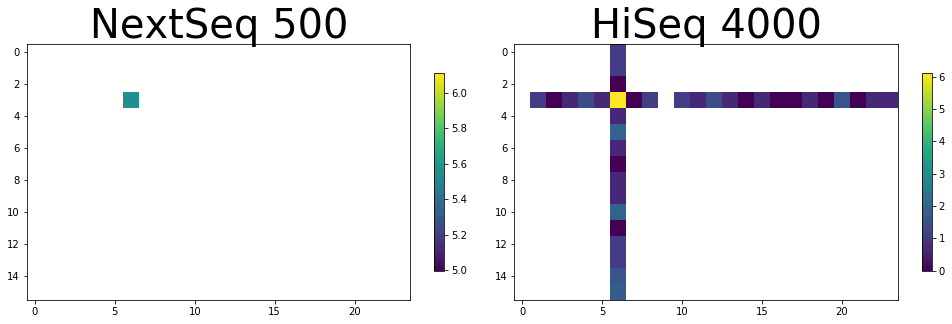

Mki67


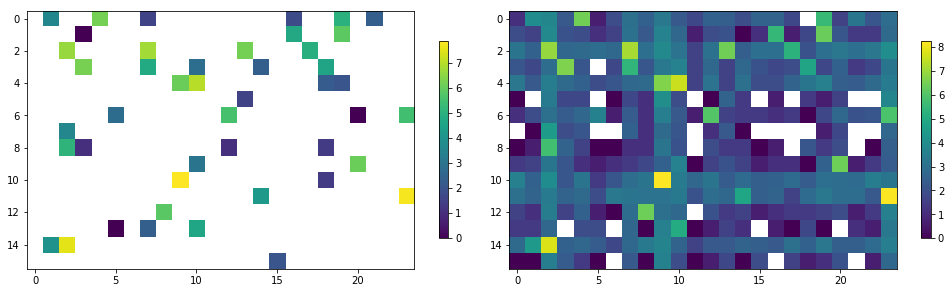

In [13]:
for gene in ['Tacr1','Mki67']:
    f, (ax1,ax2) = plt.subplots(1,2, figsize = (14,14))
    if gene == 'Tacr1':
        ax1.set_title('NextSeq 500', fontsize=40)
        ax2.set_title('HiSeq 4000', fontsize=40)
    
    im1 = ax1.imshow(np.log(np.array(df_noindex_NextSeq[gene]).reshape(16,24)), cmap='viridis', interpolation='nearest')
    f.colorbar(im1, ax=ax1, shrink=0.2)
    im2 = ax2.imshow(np.log(np.array(df_noindex[gene]).reshape(16,24)), cmap='viridis', interpolation='nearest')
    f.colorbar(im2, ax=ax2, shrink=0.2)
    f.tight_layout()
    print(gene)
    plt.show()

## Figure 1B and 1C, Estimation of index switching severity.

First, we identify genes with an expression over 30 reads counts in one cell only. The exact threshold (e.g. 30 counts) to use depend on sequencing depth and can be user-provided in the automated script (see below). Its use is to enrich for potential cases with high expression in only one cell.

In [7]:

print('Estimating spreading from {}'.format(filename))

names_list = []
for i, col in df_noindex.items():
    if num_counts(col, high) == 1:
        names_list.append(i)

n_names = len(names_list)
if n_names == 0:
    print('Found no genes useable to estimate spreading, exiting...')
true_counts = np.zeros(n_names)
spread_counts = np.zeros((n_names, n_rows+n_cols - 2))
num_wells_counts = np.zeros(n_names)

for i,namn in enumerate(names_list):
    if len(df_noindex[namn].values) == n_rows*n_cols:
        true_counts[i] = np.amax(df_noindex[namn].values)
        w = np.argwhere(df_noindex[namn].values.reshape(n_rows,n_cols) == true_counts[i])[0]
        spread_counts[i] = np.append(np.append(df_noindex[namn].values.reshape(n_rows,n_cols)[w[0], :w[1]],df_noindex[namn].values.reshape(n_rows,n_cols)[w[0], w[1]+1:] ), np.append(df_noindex[namn].values.reshape(n_rows,n_cols)[:w[0], w[1]],df_noindex[namn].values.reshape(n_rows,n_cols)[w[0]+1:, w[1]] ))
        num_wells_counts[i] = np.sum(df_noindex[namn].values != 0) - 1


Estimating spreading from mHSC_plate1HiSeq_counts_IndexInfo.csv


We then tested for each gene independently whether there was a significant increase in the probability of expression in the cells of the same row and column compared to other unrelated wells. Specifically, we let the number of wells with a count be denoted as w and the number of wells along the row and column combination of the source count with a count as s.  For each gene, we calculated the probability of observing s wells with a count out of w trials without replacement assuming that all wells are equally likely to have counts (hypergeometric test). If there are no other reads than the source read, the gene is assigned a p-value of 1. The p-values are then corrected for multiple testing (Benjamini-Hochberg, False Discovery Rate of 0.05).

In [8]:
# Used later for estimation of the rate of spreading
prop_spread = np.zeros((len(names_list), n_rows+n_cols - 2))

for i in range(len(names_list)):
    prop_spread[i] = spread_counts[i]/true_counts[i]

# Here the bias test starts
from scipy.stats import binom_test
test_bias = np.zeros(n_names)

for i in range(len(names_list)):
    test_bias[i] = hypergeom.sf(np.sum(spread_counts[i] != 0)-1, n_rows*n_cols-1, n_rows+n_cols - 2, num_wells_counts[i])

mt = multipletests(test_bias[test_bias != 1])[0]
bias_log = 'Found expression to be biased along a certain column and row combination {} times out of {}'.format(np.sum(mt), len(mt))
print(bias_log)

Found expression to be biased along a certain column and row combination 753 times out of 899


The genes which we determine as significant were then used in a linear regression model which predicts the number of spread counts (i.e. the sum of the counts for that particular row and column combination) from the number of source counts. We consider c/(c+1) as an estimate of the fraction of spread counts in the dataset, where c is the estimated coefficient in the model (in Figure 1B). To estimate the rate of spreading used in the correction, we consider the fraction of spread counts to source counts for each well where we observed spread counts. The median of the resulting values is then used in the correction (in Figure 1C).

Estimated the median rate of spreading to be 0.0098
Estimated fraction of spread reads to be 0.14827 and variance explained R-squared = 0.8996


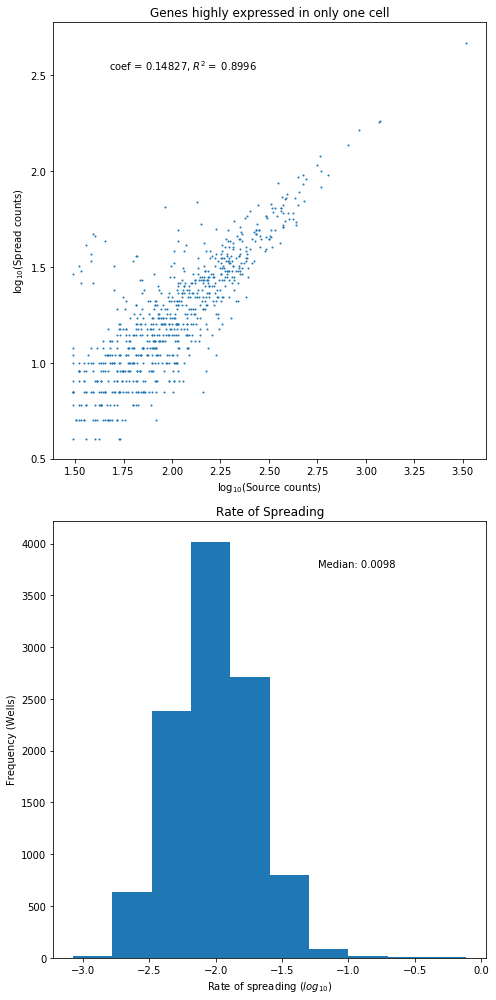

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,14))

if np.sum(mt) != 0:

    rate_spreading = np.median(prop_spread[test_bias != 1][mt].flatten()[prop_spread[test_bias != 1][mt].flatten() != 0])
    rate_log = 'Estimated the median rate of spreading to be {}'.format(np.round(rate_spreading,5))
    print(rate_log)

    ax2.hist(np.log10(prop_spread[test_bias != 1][mt].flatten()[prop_spread[test_bias != 1][mt].flatten() != 0]))
    ax2.set_title('Rate of Spreading')
    ax2.text(0.7, 0.9,'Median: ' + str(np.round(rate_spreading,5)), ha='center', va='center', transform=ax2.transAxes)
    ax2.set_ylabel('Frequency (Wells)')
    ax2.set_xlabel(r'Rate of spreading ($log_{10}$)')

    spread_counts = spread_counts[test_bias != 1][mt]
    true_counts = true_counts[test_bias != 1][mt]
    true_median = np.median(true_counts)
    model_df = pd.DataFrame([true_counts, np.apply_along_axis(np.sum, 1,spread_counts)], index=['true', 'spread']).T
    y,X = dmatrices('spread ~  true', data = model_df, return_type='dataframe')
    model = sm.OLS(y, X).fit()
    ols_log = 'Estimated fraction of spread reads to be {} and variance explained R-squared = {}'.format(np.round(model.params['true'],5), np.round(model.rsquared,5))
    print(ols_log)

    ax1.scatter(np.log10(true_counts), np.log10(np.apply_along_axis(np.sum, 1,spread_counts)), s = 1)
    ax1.set_xlabel(r'log$_{10}$(Source counts)')
    ax1.set_ylabel(r'log$_{10}$(Spread counts)')
    ax1.text(0.3, 0.9,r'coef = {}, $R^2 = $ {}'.format(np.round(model.params['true'],5), np.round(model.rsquared,5)), ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Genes highly expressed in only one cell')
else:
    print('Found no genes with bias along the column and row combination')
    rate_log = 'Found no genes with bias along the column and row combination'
    ols_log = 'Found no genes with bias along the column and row combination'

plt.tight_layout()
plt.show()

if np.sum(mt) == 0 or model.params['true'] < threshold:
    print('The experiment shows no or an acceptable amount of spreading, correction is not neccesary. Exiting...')



## Computational correction procedure.
The observed read counts in each well can be considered a linear combination of true signal spreading along columns and rows of the plate. Let A be a n × n matrix of the modelled spread along the column of the plate due to the n P5 index primers, and B a m × m matrix of the modelled spread along the row of the plate due to the m P7 index primers. Every entry of these matrices is the rate of spreading between that particular primer combination. Along the diagonal of the matrices we set the rate of spreading to 0.5 in order to preserve the true counts. We assume that the rate of spreading does not differ between primer combinations, but the correction procedure allows for unequal rates of spreading by modifying the entries. Let X be an n × m matrix representing the true counts in each well. Then our observed count matrix C for each gene is the column spread (AX) plus the row spread (XB). We have the resulting equation AX+XB=C. This type of matrix equation is called a Sylvester equation, which is well studied in the mathematical field of control theory. In addition, it is worth noting that for our purposes the matrices A and B which we use to model our spread are always constructed such that X has a unique solution, since the A and –B do not share any eigenvalues. Algorithms to solve this kind of equation are available in most programming languages. We used the scientific python (scipy) implementation to solve the Sylvester equation.

In [10]:

column_spread = np.zeros((n_rows, n_rows))
row_spread = np.zeros((n_cols,n_cols))
column_spread[:,:] = rate_spreading
row_spread[:,:] = rate_spreading
np.fill_diagonal(column_spread, 0.5 - rate_spreading/2)
np.fill_diagonal(row_spread, 0.5 - rate_spreading/2)

def adjust_reads(mat, column_spread = column_spread, row_spread = row_spread, cutoff = c, r = n_rows, c = n_cols):
    mat = np.array(mat).flatten()
    mat = mat.reshape(r,c)
    adjusted_reads = np.rint(solve_sylvester(column_spread,row_spread,mat))
    # A lower bound cutoff removes false positives (unfortunately also remove true reads with low counts in that cell)
    adjusted_reads[adjusted_reads < cutoff] = 0
    return adjusted_reads

print('Correcting spreading for each gene')

adj_list = []
for i, col in df_noindex.items():
    adj_list.append(adjust_reads(col).flatten())

df_adj = pd.DataFrame(data=adj_list, index = df_noindex.columns.values, columns= df_noindex.index.values).T

df_adj = pd.concat([df[i7_index_name], df[i5_index_name] , df_adj], axis = 1)

print('Saving correction to {}'.format('{}_corrected.csv'.format(base)))

df_adj.to_csv('{}_corrected.csv'.format(base))

Correcting spreading for each gene
Saving correction to mHSC_plate1HiSeq_counts_IndexInfo_corrected.csv


## Supplemental Figure 1A

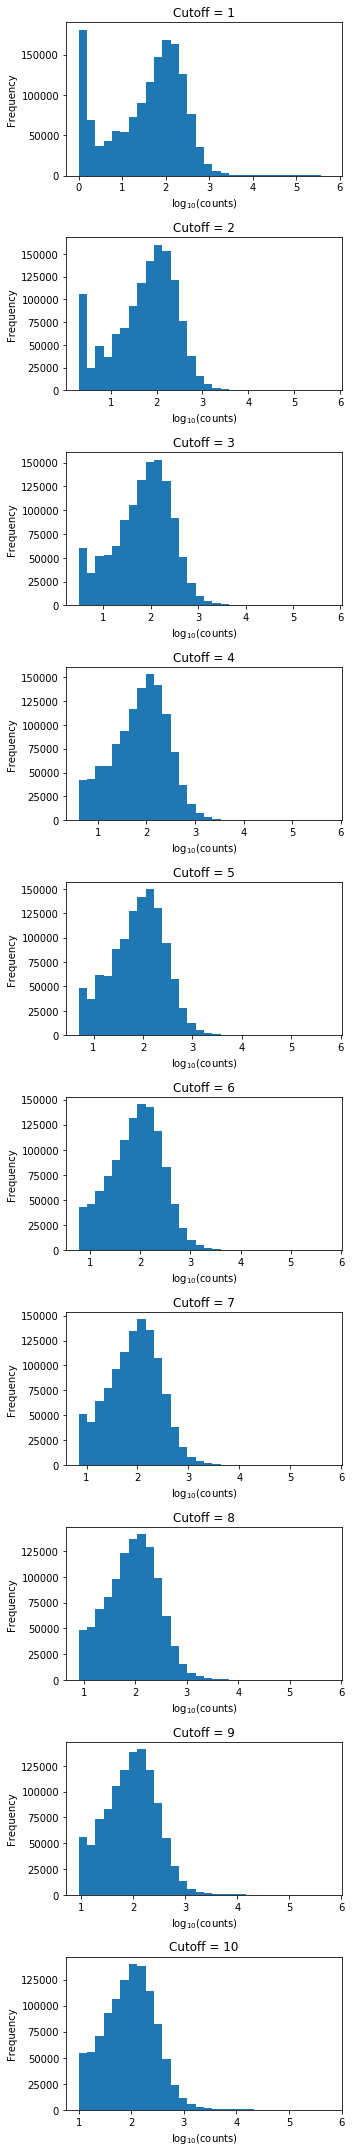

In [80]:
f, axes = plt.subplots(10,1, figsize=(5,30))
for c in np.arange(1,11):
    li = []
    for i, col in df_noindex.items():
        li.append(adjust_reads(col, cutoff = c).flatten())
    li_adj = pd.DataFrame(data=li, index = df_noindex.columns.values, columns= df_noindex.index.values).T
    axes[c-1].set_title('Cutoff = {}'.format(c))
    axes[c-1].hist(np.log10(li_adj.values.flatten()[(li_adj.values.flatten() > 0) ]), bins = 30)
    axes[c-1].set_xlabel(r'log$_{10}$(counts)')
    axes[c-1].set_ylabel('Frequency')
f.tight_layout()
plt.show()

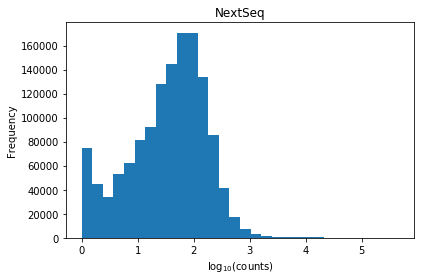

In [73]:
plt.hist(np.log10(df_noindex_NextSeq.values.flatten()[(df_noindex_NextSeq.values.flatten() > 0) ]), bins = 30)
plt.title('NextSeq')
plt.xlabel(r'log$_{10}$(counts)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Figure 1D

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Tacr1


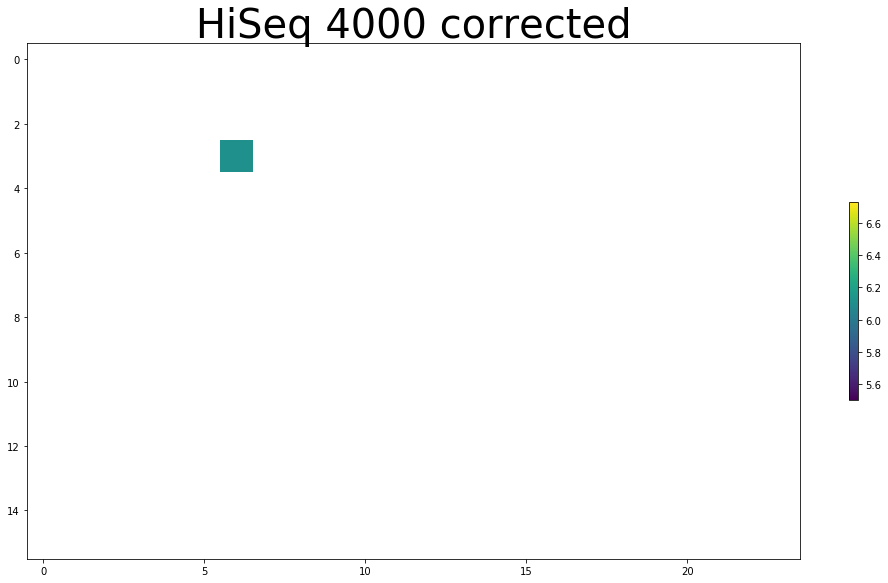

Mki67


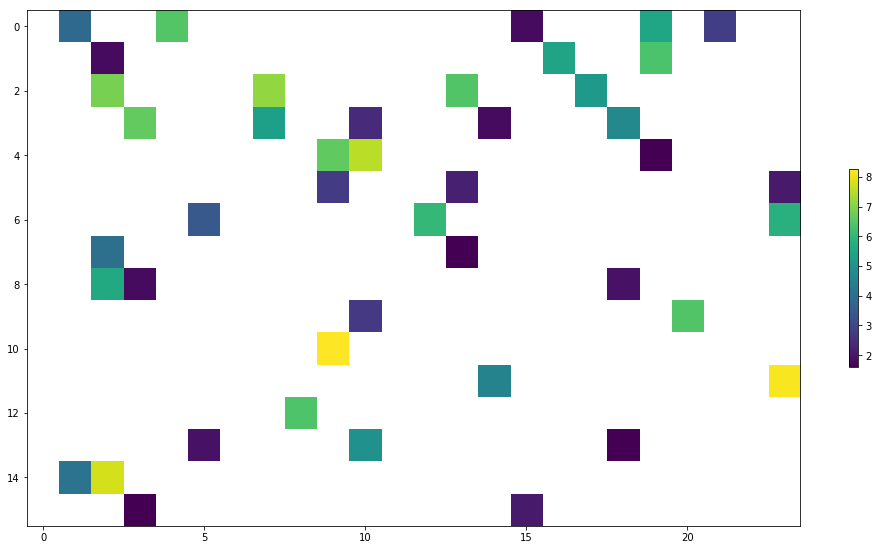

In [14]:
for gene in ['Tacr1','Mki67']:
    f, ax1 = plt.subplots(1,1, figsize = (14,14))
    if gene == 'Tacr1':
        ax1.set_title('HiSeq 4000 corrected', fontsize=40)
    
    im1 = ax1.imshow(np.log(np.array(df_adj[gene]).reshape(16,24)), cmap='viridis', interpolation='nearest')
    f.colorbar(im1, ax=ax1, shrink=0.2)
    f.tight_layout()
    print(gene)
    plt.show()

In [22]:
correction_logs = pd.read_csv('all_unspread_logs.txt', sep='\t', header=None)
correction_logs = correction_logs.fillna(0) 
# Dealing with degenerate case of regression, negative coefficient 
correction_logs.at[18,4] = 0

In [24]:
correction_logs[7] = ['green','green','green','green','green', 'yellow', 'green', 'blue', 'yellow', 'green', 'green', 'green', 'green', 'blue', 'blue','blue','blue','blue','blue']
correction_logs[8] = ['Affected', 'Affected', 'Affected','Affected', 'Affected','Corrected', 'Affected', 'Unaffected','Corrected', 'Affected', 'Affected','Affected','Affected', 'Unaffected','Unaffected','Unaffected','Unaffected','Unaffected','Unaffected']

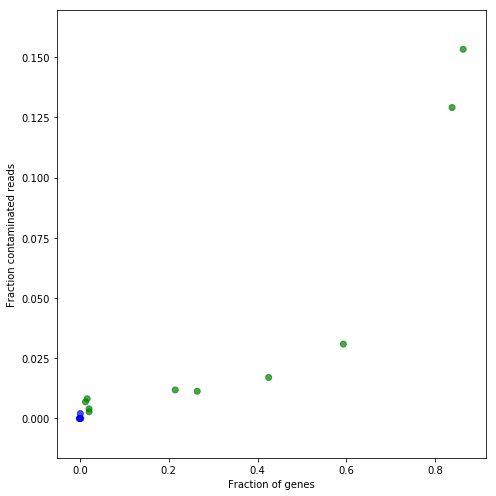

In [25]:
plt.figure(figsize=(7,7))
plt.scatter(correction_logs[1]/correction_logs[2], correction_logs[4]/(1+correction_logs[4]), alpha = 0.7, c = correction_logs[7])
plt.xlabel('Fraction of genes')
plt.ylabel('Fraction contaminated reads')
plt.tight_layout()
plt.show()

## Figure 2A-C
To systematically quantify the degree to which the correction removes the cross-contamination signal, we defined expression detected in the HiSeq data but not the NextSeq data as false positives and likewise expression only detected on the NextSeq as false negatives.

In [58]:
def only_cutoff(mat):
    mat = np.array(mat).flatten()
    mat = mat.reshape(n_rows,n_cols)
    mat[mat < 5] = 0
    return mat

In [59]:
true_list = []
for i, col in df_noindex_NextSeq.items():
    true_list.append(np.array(col))
spread_list = []
only_cutoff_list = []
for i, col in df_noindex.items():
    spread_list.append(np.array(col))
    only_cutoff_list.append(only_cutoff(col).flatten())

In [60]:
def calc_fp(arr1, arr2):
    if np.sum(np.array(arr1)) == 0:
        return np.nan
    else:
        return np.mean(((np.array(arr1) == 0)  & (np.array(arr2) > 0)))
def calc_fn(arr1, arr2):
    if np.sum(np.array(arr1)) == 0:
        return np.nan
    else:
        return np.mean((np.array(arr1) > 0)  & (np.array(arr2) == 0))

In [61]:
adj_fp = np.array([])
spread_fp = np.array([])
cutoff_fp = np.array([])
for true, adj, cutoff, spread in zip(true_list, adj_list, only_cutoff_list, spread_list):
    adj_fp = np.append(adj_fp, calc_fp(true,adj))
    cutoff_fp = np.append(cutoff_fp, calc_fp(true,cutoff))
    spread_fp = np.append(spread_fp, calc_fp(true,spread))
fp_ratio = adj_fp/spread_fp
cutoff_fp_ratio = cutoff_fp/spread_fp

/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/mnt/kauffman/nbserver/jupyter-run-software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [62]:
adj_fn = np.array([])
spread_fn = np.array([])
cutoff_fn = np.array([])
for true, adj, cutoff, spread in zip(true_list, adj_list, only_cutoff_list, spread_list):
    adj_fn = np.append(adj_fn, calc_fn(true,adj))
    cutoff_fn = np.append(cutoff_fn, calc_fn(true, cutoff))
    spread_fn = np.append(spread_fn, calc_fn(true,spread))

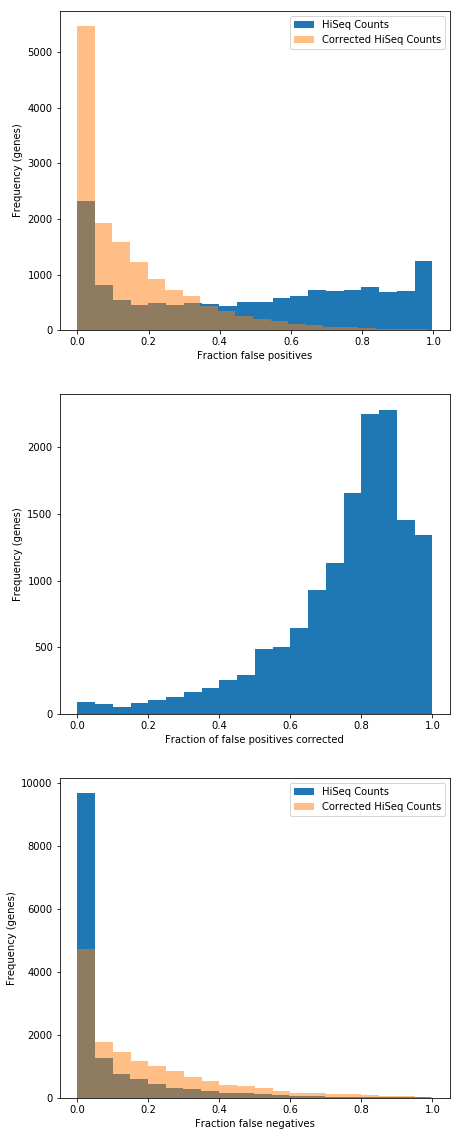

In [88]:
f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (7,20))
ax1.hist(spread_fp[~np.isnan(spread_fp)], bins = 20, label = 'HiSeq Counts')
ax1.hist(adj_fp[~np.isnan(adj_fp)], alpha = 0.5, bins = 20, label = 'Corrected HiSeq Counts')
ax1.set_xlabel('Fraction false positives')
ax1.set_ylabel('Frequency (genes)')
ax1.legend()
ax2.hist(1-fp_ratio[~np.isnan(fp_ratio)], bins = 20)
ax2.set_xlabel('Fraction of false positives corrected')
ax2.set_ylabel('Frequency (genes)')
ax3.hist(spread_fn[~np.isnan(spread_fn)], bins = 20, label = 'HiSeq Counts')
ax3.hist(adj_fn[~np.isnan(adj_fn)], alpha = 0.5, bins = 20, label = 'Corrected HiSeq Counts')
ax3.legend()
ax3.set_xlabel('Fraction false negatives')
ax3.set_ylabel('Frequency (genes)')
plt.show()

## Supplemental Figure 2 A-C
We note that simply applying a cut-off to the uncorrected dataset is not sufficient to recover the true expression since the cross-contamination spread signal has a large dynamic range.

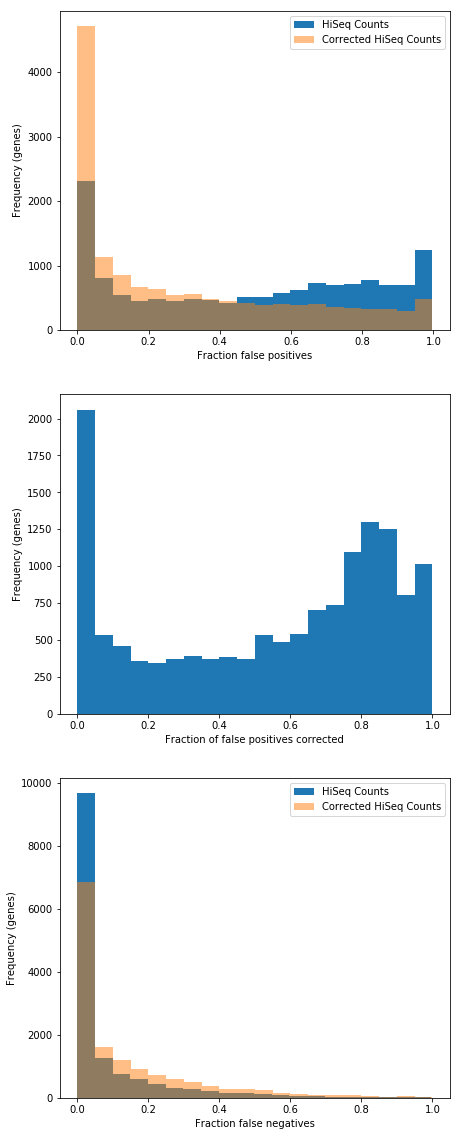

In [83]:
f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (7,20))
ax1.hist(spread_fp[~np.isnan(spread_fp)], bins = 20, label = 'HiSeq Counts')
ax1.hist(cutoff_fp[~np.isnan(cutoff_fp)], alpha = 0.5, bins = 20, label = 'Corrected HiSeq Counts')
ax1.set_xlabel('Fraction false positives')
ax1.set_ylabel('Frequency (genes)')
ax1.legend()
ax2.hist(1-cutoff_fp_ratio[~np.isnan(cutoff_fp_ratio)], bins = 20)
ax2.set_xlabel('Fraction of false positives corrected')
ax2.set_ylabel('Frequency (genes)')
ax3.hist(spread_fn[~np.isnan(spread_fn)], bins = 20, label = 'HiSeq Counts')
ax3.hist(cutoff_fn[~np.isnan(cutoff_fn)], alpha = 0.5, bins = 20, label = 'Corrected HiSeq Counts')
ax3.legend()
ax3.set_xlabel('Fraction false negatives')
ax3.set_ylabel('Frequency (genes)')
plt.show()